# Model Testing

## This notebook is meant to load trained models, and test their performance



In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from dataset_spectrogram import EEGDataset
from torch.utils.data import random_split
import neptune.new as neptune
from torchinfo import summary
from dataset_spectrogram import load_dataset
import random
import torch.utils.data as data
from datetime import datetime
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import mne

Spectrogram dataset version 20 non log


In [2]:
# Load a saved model

device = 'cuda' if torch.cuda.is_available() else 'cpu' #Check for cuda 
print(device)

model = torch.jit.load("../trained_models/model_05_15_2022_01_45_51",map_location=device) #Best model
#model = torch.jit.load("../trained_models/model_05_12_2022_06_10_52",map_location=device) #Earlier model


cpu


### Load and test with 50-50 test dataset

In [3]:
# Load the dataset
raw_data_dir = '../data'
testNights = 8

print("\nTest set\n")
test_set = load_dataset(range(testNights), raw_data_dir, normalized = False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, drop_last = True)

# Test the model on the test set

size = len(test_loader.dataset)
num_batches = len(test_loader)
correct = 0

# Truth table variables
true_pos,true_neg, false_pos, false_neg = 0,0,0,0

predicted_count = 0

with torch.no_grad():
    for X, y in test_loader:
        X = X[:,None,:,:].to(device)
        y = y.to(device)
        pred = model(X).reshape(-1).to(device) # Reshape to 1 dimension if using binary classification, otherwise keep dimensions from model output
        correct += (pred.round() == y).type(torch.float).sum().item()
        
        # Calculate the confusion matrix
        for i, pred_val in enumerate(pred.round()):
            if y[i] == 1:
                if pred_val == 1:
                    true_pos += 1
                else:
                    false_neg += 1
            else:
                if pred_val == 1:
                    false_pos += 1
                else:
                    true_neg += 1
        
        predicted_count += 1
        if (predicted_count % 100) == 0:
            print("Batch: ", predicted_count, "Correct: ", correct, "Accuracy: ", correct/size, "Of", num_batches)
                    
        

correct /= size
print(f"Test accuracy: {correct}")
print(f"Test size: {size}")

# Print the confusion matrix
print("\nTruth table\n")
print(f"True pos: {true_pos}")
print(f"True neg: {true_neg}")
print(f"False pos: {false_pos}")
print(f"False neg: {false_neg}")

print("\n\n")

# This takes around 5 minutes to run


Test set

../data/study_1A_mat_simple/S_01/night_1/spectrogram_bad_segments_unnormalized.npy
../data/study_1A_mat_simple/S_01/night_1/spectrogram_good_segments_unnormalized.npy
Memory usage: 0.032764 MB

Lengths:

Good data length: 7368
Bad data length: 7368
Caluculated length: 14735
../data/study_1A_mat_simple/S_01/night_2/spectrogram_bad_segments_unnormalized.npy
../data/study_1A_mat_simple/S_01/night_2/spectrogram_good_segments_unnormalized.npy
Memory usage: 0.038863 MB

Lengths:

Good data length: 4292
Bad data length: 4292
Caluculated length: 8583
../data/study_1A_mat_simple/S_01/night_3/spectrogram_bad_segments_unnormalized.npy
../data/study_1A_mat_simple/S_01/night_3/spectrogram_good_segments_unnormalized.npy
Memory usage: 0.042374 MB

Lengths:

Good data length: 6110
Bad data length: 6110
Caluculated length: 12219
../data/study_1A_mat_simple/S_01/night_4/spectrogram_bad_segments_unnormalized.npy
../data/study_1A_mat_simple/S_01/night_4/spectrogram_good_segments_unnormalized.np

### Load and test full night data

In [4]:
# Make a list of all the folders containing sleep data

raw_data_dir = '../data'
data_dirs = []

for subdir, dirs, files in sorted(os.walk(raw_data_dir)):
    if "night" in subdir and not ("calibration" in subdir or "scor" in subdir or "folder" in subdir):
        data_dirs.append(subdir)
        
print(f"{len(data_dirs)} nights found")       

77 nights found


#### Load data

In [5]:
annotation_list,spectrogram_list, time_series_list, channel_list = [],[],[],[] # Create lists to store the data
for i in range(8):
    # Load the spectrogram data from a night from the list
    night_path = data_dirs[i]

    time_series = np.load(f"{night_path}/EEG_raw_250hz.npy") # Load the raw EEG data
    print('Time series data loaded')

    f, t, Sxx = signal.spectrogram(time_series[:], fs=250,nperseg=250, noverlap=125) # Calculate the spectrogram
    print('Spectrogram complete')

    annotations = np.load(night_path+"/artefact_annotations.npy") # Load the annotations
    print("Annotations loaded")



    # Segment the data, and add to lists
    for channel_number, channel in enumerate(Sxx): # Loop through each channel
        for i in range(channel.shape[1]): # Loop through each timepoint
            if (i % 20 == 0) and i < channel.shape[1] - 21: # Segment the data into 10s windows
                
                annotation_list.append(annotations[:,i*125:i*125+2500]) # Load annotations for the segment
                spectrogram_list.append(channel[:,i:i+20]) # Load the spectrogram for the segment
                time_series_list.append(time_series[:,i*125:i*125+2500]) # Load the time series for the segment
                channel_list.append(channel_number) # Load the channel number for the segment
                


# Print list lengths
print(f"Annotation list length: {len(annotation_list)}")
print(f"Spectrogram list length: {len(spectrogram_list)}")
print(f"Time series list length: {len(time_series_list)}")
print(f"Channel list length: {len(channel_list)}")
print("Lists created")


Time series data loaded
Spectrogram complete
Annotations loaded
Time series data loaded
Spectrogram complete
Annotations loaded
Time series data loaded
Spectrogram complete
Annotations loaded
Time series data loaded
Spectrogram complete
Annotations loaded
Time series data loaded
Spectrogram complete
Annotations loaded
Time series data loaded
Spectrogram complete
Annotations loaded
Time series data loaded
Spectrogram complete
Annotations loaded
Time series data loaded
Spectrogram complete
Annotations loaded
Annotation list length: 570625
Spectrogram list length: 570625
Time series list length: 570625
Channel list length: 570625
Lists created


#### Predict artefacts using trained model

In [6]:
pred = []
for n in range(len(spectrogram_list)): # Loop through each segment
    if n % 64 == 0: # If the segment is a multiple of 64, predict the batch of segments
        print(f"Segment {n}/{len(spectrogram_list)}")     
        spectro_tensor = torch.from_numpy(np.array(spectrogram_list[n:n+64]))
        spectro_tensor = spectro_tensor[:,None,:,:]
        
        batch_pred = model(spectro_tensor) # Run the model on the segments
        for i in range(batch_pred.shape[0]): # Add the predictions to the list
            pred.append(float(batch_pred[i])) 
         
    
    # MNE normalize raw data 
    
    
    # Visualise the segment 
    # raw.plot(block=True)

Segment 0/570625
Segment 64/570625
Segment 128/570625
Segment 192/570625
Segment 256/570625
Segment 320/570625
Segment 384/570625
Segment 448/570625
Segment 512/570625
Segment 576/570625
Segment 640/570625
Segment 704/570625
Segment 768/570625
Segment 832/570625
Segment 896/570625
Segment 960/570625
Segment 1024/570625
Segment 1088/570625
Segment 1152/570625
Segment 1216/570625
Segment 1280/570625
Segment 1344/570625
Segment 1408/570625
Segment 1472/570625
Segment 1536/570625
Segment 1600/570625
Segment 1664/570625
Segment 1728/570625
Segment 1792/570625
Segment 1856/570625
Segment 1920/570625
Segment 1984/570625
Segment 2048/570625
Segment 2112/570625
Segment 2176/570625
Segment 2240/570625
Segment 2304/570625
Segment 2368/570625
Segment 2432/570625
Segment 2496/570625
Segment 2560/570625
Segment 2624/570625
Segment 2688/570625
Segment 2752/570625
Segment 2816/570625
Segment 2880/570625
Segment 2944/570625
Segment 3008/570625
Segment 3072/570625
Segment 3136/570625
Segment 3200/570625

#### Calculate accuracy on real data (not sorted to 50-50 artefacts)

In [7]:
print("Calculate artefact ratio for each segment")
artefact_ratios = []
for i in range(len(pred)):
    artefact_ratios.append(annotation_list[i][channel_list[i]].sum()/2500)

print("Ratios calculated")
y = [math.ceil(x) for x in artefact_ratios] # The target values for the predictions (Whether the segment is an artefact)
pred_rounded = [round(x) for x in pred] # The predicted values(Whether the segment is an artefact)

true_pos,true_neg, false_pos, false_neg = 0,0,0,0

 # Calculate the confusion matrix
for i, pred_val in enumerate(pred_rounded):
    if y[i] == 1:
        if pred_val == 1:
            true_pos += 1
        else:
            false_neg += 1
    else:
        if pred_val == 1:
            false_pos += 1
        else:
            true_neg += 1
          
# Print the confusion matrix
print("\nConfusion matrix\n")
print(f"True pos: {true_pos}")
print(f"True neg: {true_neg}")
print(f"False pos: {false_pos}")
print(f"False neg: {false_neg}")
# Calculate and print the accuracy
accuracy = (true_pos + true_neg)/(true_pos + true_neg + false_pos + false_neg)
print(f"Accuracy: {accuracy}")

print("\n\n")  


Calculate artefact ratio for each segment
Ratios calculated

Confusion matrix

True pos: 65105
True neg: 417033
False pos: 77549
False neg: 10938
Accuracy: 0.844929682365827





#### Plot

In [8]:

# Pick a random index of a segment to plot
while True:
    segment_index = round(random.random()*len(time_series_list)) 
    channel = round(random.random()*24) 
    
    #if sum(sum(annotation_list[segment_index])) == 0: # Condition for the plot to show
    if pred_rounded[segment_index] == 1 and y[segment_index] == 0: # Condition for the plot to show
        print("Plotting segment")
        print(f"Index: {segment_index}")
        print(f"Channel: {channel}")
        break
    


Plotting segment
Index: 62664
Channel: 23


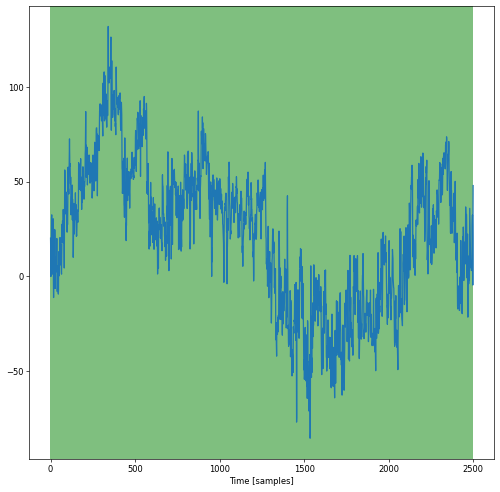

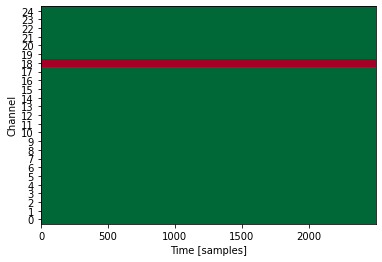

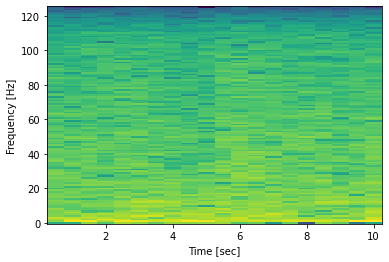

In [9]:
channel = 13


# Convert time series to mne raw object
labels = list(range(25)) #MNE needs labels for channels (Numbers as placeholder. Should ideally be the correct labels)
labels = [str(i) for i in labels]
#raw = mne.io.RawArray(time_series_list[segment_index], info=mne.create_info(labels, 250))

# Plot time series using matplotlib and color code the segments with artefact info
plt.figure(figsize=(10,10), dpi=60)
#plt.subplot(2,1,1)
plt.plot(time_series_list[segment_index][channel])
for i, a in enumerate(annotation_list[segment_index][channel]):
    if a:
        plt.axvspan(i - 0.5, i + 0.5, facecolor='r', alpha=0.5)
    else:
        plt.axvspan(i - 0.5, i + 0.5, facecolor='g', alpha=0.5)
plt.xlabel('Time [samples]')
plt.show()


# Plot artefact annotations across all channels in the same segment
#plt.subplot(2,1,2)
plt.pcolormesh(range(2500), labels, annotation_list[segment_index], cmap=plt.get_cmap('RdYlGn_r'),shading='auto')
plt.xlabel('Time [samples]')
plt.ylabel('Channel')
plt.show()


# Plot spectrogram
plt.pcolormesh(t[0:20], f, np.log(spectrogram_list[segment_index]),shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
    



    

#### Plot histogram of False negative artefact ratios

FN ratio list done
Average FN ratio: 0.688851051380507
Average TP ratio: 0.7470001382382407


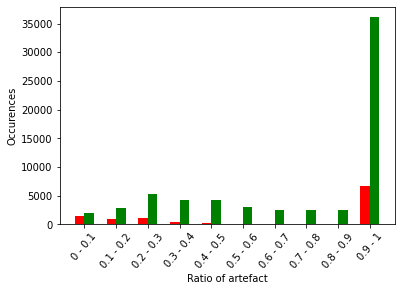

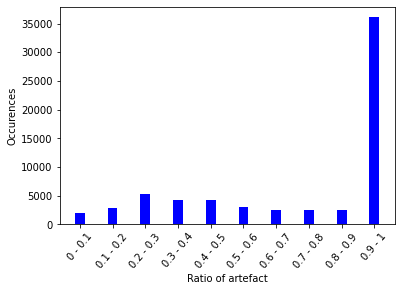

In [10]:

FN_ratio_list = [] # False negative ratio list
TP_ratio_list = [] # True negative ratio list
#art_ratio_list = [x for x in artefact_ratios > 0] # List of ratios of all segments with artefacts

# Using code from confusion matrix
for i, pred_val in enumerate(pred_rounded):
    if y[i] == 1:
        if pred_val == 1:
            true_pos += 1
            TP_ratio_list.append(artefact_ratios[i])
        else:
            false_neg += 1
            FN_ratio_list.append(artefact_ratios[i])
    else:
        if pred_val == 1:
            false_pos += 1
        else:
            true_neg += 1
            
            
print("FN ratio list done")

# Print average of artefact_ratios
print(f"Average FN ratio: {sum(FN_ratio_list)/len(FN_ratio_list)}")
print(f"Average TP ratio: {sum(TP_ratio_list)/len(TP_ratio_list)}")

FN_bar_list = []
TP_bar_list = []
bar_list = []

for i in range(10):
    FN_bar_list.append(len([x for x in FN_ratio_list if x > i/10 and x <= (i+1)/10]))
    TP_bar_list.append(len([x for x in TP_ratio_list if x > i/10 and x <= (i+1)/10]))
    bar_list.append(len([x for x in artefact_ratios if x > i/10 and x <= (i+1)/10]))
    
# https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/barchart.html    
    
labels = ['0 - 0.1','0.1 - 0.2','0.2 - 0.3','0.3 - 0.4','0.4 - 0.5','0.5 - 0.6','0.6 - 0.7','0.7 - 0.8','0.8 - 0.9','0.9 - 1']
x = np.arange(len(labels))
#plt.bar((np.arange(10)/10)-0.05, FN_bar_list, color='r', width=0.05)
plt.bar(x-0.15, FN_bar_list, color='r', width=0.3)
plt.bar(x+0.15, TP_bar_list, color='g', width=0.3)

ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation = 50)
plt.xlabel('Ratio of artefact')
plt.ylabel('Occurences')
plt.show()


# Create a bar graph for all artefacts in the test set
plt.bar(x, TP_bar_list, color='b', width=0.3)

ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation = 50)
plt.xlabel('Ratio of artefact')
plt.ylabel('Occurences')
plt.show()


#### Plot standard deviation vs worst standard deviation

In [11]:
print("\n\n")

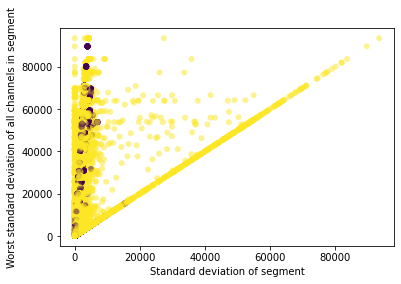

In [12]:
std_list = []
worst_std_list = []
correct_pred_list = []
plot_len = len(pred_rounded)
for i in range(plot_len):
    if pred_rounded[i] == y[i]:
        correct_pred_list.append(1)
    else: 
        correct_pred_list.append(0)
    
    std_list.append(np.std(time_series_list[i][channel_list[i],:]))
    biggest_std = 0
    for channel in range(25): # Get standard deviation of all channels in the segment
        if np.std(time_series_list[i][channel,:]) > biggest_std:
            biggest_std = np.std(time_series_list[i][channel,:])
    worst_std_list.append(biggest_std)
    

plt.scatter(std_list, worst_std_list, c = correct_pred_list, alpha=0.5, edgecolors='none')
plt.xlabel('Standard deviation of segment')
plt.ylabel('Worst standard deviation of all channels in segment')
plt.show()
        
    